# **Spam Detector**

In this project, the spam detector is built to classify the normal text and spam text. Several classification algorithms (Linear Regression, Multinomial Naive Bayes, Linear SVM, Kernel SVM, Random Forest and AdaBoost) will be investigated and evaluated. The dataset used in this project can be downloaded from https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from wordcloud import WordCloud
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns

## **Data Pre-processing**

In [ ]:
from google.colab import files

files.upload()

In [2]:
df = pd.read_csv('spam.csv', encoding= 'ISO-8859-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Change  the column names and convert labels into binary

In [4]:
df = df[['v1','v2']]
df = df.rename(columns={'v1': 'labels', 'v2': 'text'})
df.head()

,labels,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Use wordCloud package to visualize the most frequent words appear in both spam and no-spam text

In [7]:
# visualize the data
def visualize(label):
  words = ''
  for msg in df[df['labels'] == label]['text']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

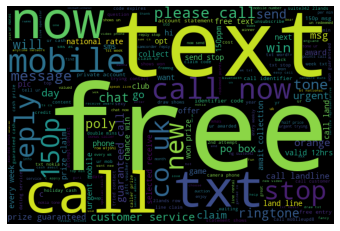

In [8]:
visualize('spam')

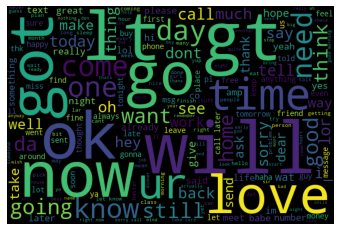

In [9]:
visualize('ham')

In [5]:
df['labels'] = df['labels'].map({'ham': 0, 'spam': 1})
df.head()

,labels,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
df.shape

(5572, 2)

In [21]:
df.groupby(['labels']).count()

,text
labels,
0,4825
1,747


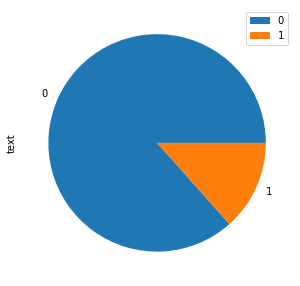

In [22]:
plot = df.groupby(['labels']).count().plot.pie(y='text', figsize=(5, 5))

Noted that this is a unbalanced dataset, with 13.4% spam text, 86.6% non-spam text.

## **TF-IDF Feature Generation**

The TF-IDF is used to generate the feature vector from text.

[Term frequency–inverse document frequency (TF-IDF)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length as a way of normalization.

\begin{equation*}
TF(t) = \frac{count_{t,d}}{count_{t,d_{total}}}
\end{equation*}

where $t$ is the term, $count_{t,d}$ is the number of term $t$ appears in the document $d$, $count_{t,d_{total}}$ is the total number of term $t$ appears in all of the documents.

IDF: Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

\begin{equation*}
IDF(t) = ln(\frac{N}{N_{t}})
\end{equation*}

where $N$ is the total number of documents, $N_{t}$ is the number of documents with term $t$ in it.

So the TF-IDF is the multiplication of TF and IDF

\begin{equation*}
TFIDF(t) = TF(t)IDF(t)
\end{equation*}

Fortunately, the scikit-learn can gnerate tf-idf directly by using *TfidfVectorizer* package.

TfidfVectorizer class can be initialized with the following parameters:

*   `min_df`: remove the words from the vocabulary which have occurred in less than `min_df` number of files.
*   `max_df`: remove the words from the vocabulary which have occurred in more than `max_df`: total number of files in corpus.
*   `sublinear_tf`: set to True to scale the term frequency in logarithmic scale.
*   `stop_words`: remove the predefined stop words in 'english'.
*   `use_idf`: weight factor must use inverse document frequency.
*    `ngram_range`: (1, 2) to indicate that unigrams and bigrams will be considered.

### **Analyze the data**

In [6]:
tfidfall = TfidfVectorizer(max_df=0.5, decode_error='ignore', ngram_range=(1,2))
features = tfidfall.fit_transform(df.text)
labels = df.labels

In [7]:
# Finding the ten most correlated terms with each of the labels
N = 10

features_chi2 = chi2(features, labels)
indices = np.argsort(features_chi2[0])
feature_names = np.array(tfidfall.get_feature_names())[indices]
unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

  * Most Correlated Unigrams are: stop, 150p, uk, call, www, mobile, prize, free, claim, txt
  * Most Correlated Bigrams are: 1000 cash, stop to, please call, cash or, you have, to contact, co uk, to claim, your mobile, have won


Alternatively, the feature vector can also be represented by simply the count of each term.

In [29]:
count_vectorizer = CountVectorizer(decode_error='ignore',max_df=0.5, ngram_range=(1,2))
featurescnt = count_vectorizer.fit_transform(tfidfall)

## **Classification Models**

The classification models will be evaluated are:

* Logistic Regression
* Linear and Kernel Support Vector Machine
* Multinomial Naive Bayes
* Random Forest
* AdaBoost

In [8]:
models = [
          LogisticRegression(random_state=0),
          SVC(kernel='linear', random_state=0),
          SVC(kernel='rbf', random_state=0),
          MultinomialNB(),
          RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
          AdaBoostClassifier(n_estimators=100, random_state=0)
]

In [9]:
# set 5 cross-validation
CV = 5
cv_df = pd.DataFrame(index = range(CV * len(models)))

In [10]:
entries=  []
for model in models:
  model_name = model.__class__.__name__
  if model_name == 'SVC':
    model_name = model_name + ' ({})'.format(model.kernel)
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV,)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

In [11]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,LogisticRegression,0,0.945291
1,LogisticRegression,1,0.943498
2,LogisticRegression,2,0.946140
3,LogisticRegression,3,0.931777
4,LogisticRegression,4,0.944345
5,SVC (linear),0,0.979372
6,SVC (linear),1,0.982063
7,SVC (linear),2,0.982047
8,SVC (linear),3,0.976661
9,SVC (linear),4,0.981149


Group the classifier and calculate the mean of their accuracy.

In [12]:
mean_accuracy = cv_df.groupby(['model_name']).accuracy.mean()
std_accuracy = cv_df.groupby(['model_name']).accuracy.std()

accdf = pd.concat([mean_accuracy, std_accuracy], axis=1, ignore_index=True)

accdf.columns = ['Mean Accuray', 'STD Accuracy']
accdf

,Mean Accuray,STD Accuracy
model_name,,
AdaBoostClassifier,0.979719,0.004386
LogisticRegression,0.942210,0.005916
MultinomialNB,0.943287,0.005777
RandomForestClassifier,0.866117,0.000694
SVC (linear),0.980258,0.002290
SVC (rbf),0.963029,0.002144


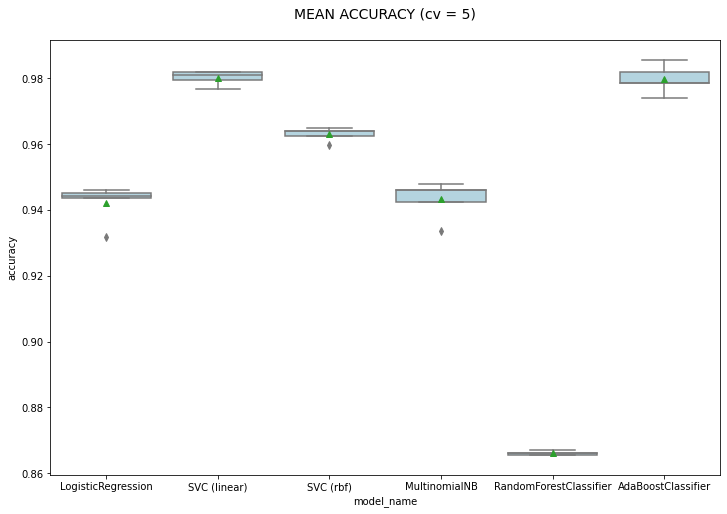

In [53]:
plt.figure(figsize=(12,8))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

From  the accuracy figure, the SVM with linear kernel has the best performance. Next, use the training set and test set to evaluate the model.

Split the dataset into training set and test set.

In [13]:
Xdftrain, Xdftest, Ydftrain, Ydftest = train_test_split(features, labels, test_size=0.33, random_state=1)
SVMmodel = SVC(kernel='linear')
SVMmodel.fit(Xdftrain, Ydftrain)
y_pred_LinearSVM = SVMmodel.predict(Xdftest)

### **Precision, Recall and F1 Score**

In [14]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(Ydftest, y_pred_LinearSVM))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1598
           1       1.00      0.84      0.91       241

    accuracy                           0.98      1839
   macro avg       0.99      0.92      0.95      1839
weighted avg       0.98      0.98      0.98      1839



In [15]:
Xdftrain, Xdftest, Ydftrain, Ydftest = train_test_split(features, labels, test_size=0.33, random_state=1)
Adamodel = AdaBoostClassifier(n_estimators=300)
Adamodel.fit(Xdftrain, Ydftrain)
y_pred_AdaBoost = Adamodel.predict(Xdftest)

In [16]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(Ydftest, y_pred_AdaBoost))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1598
           1       0.97      0.89      0.93       241

    accuracy                           0.98      1839
   macro avg       0.98      0.94      0.96      1839
weighted avg       0.98      0.98      0.98      1839



Noted that the model performs better on non-spam data, since the dataset is un-balanced with more support on leabel 0, which leads to less training samples for spam text.

### **Confusion Matrix**


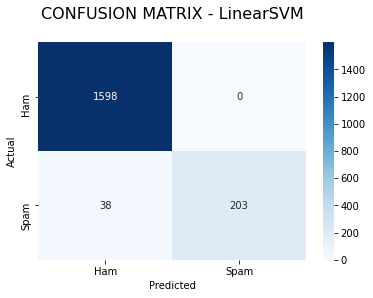

In [17]:
conf_mat = confusion_matrix(Ydftest, y_pred_LinearSVM)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVM\n", size=16);

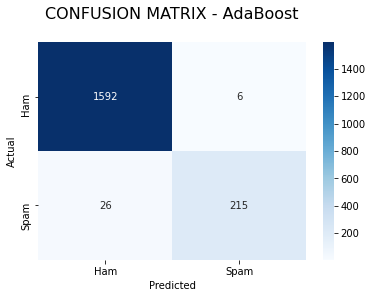

In [18]:
conf_mat = confusion_matrix(Ydftest, y_pred_AdaBoost)
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=['Ham', 'Spam'], 
            yticklabels=['Ham', 'Spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - AdaBoost\n", size=16);

## **Conclusion**

In this Spam Detector project, the classification models include Logistic Regression, Linear and Kernel Support Vector Machine, Multinomial Naive Bayes, Random Forest and AdaBoost are evaluated, among these models, the Linear kernel SVM and AdaBoost has the best accuracy, as well as precision, recall and f1-score. However, once these two models are utimlized to classify the Spam messages for unseen data (test set), the Linear SVM has better performance, since from the comfusion matrices of these two models show that for AdaBoost model, there are few examples of non-spam messages have classified as spam messages, while Linear SVM has no such mistake. In this paticular application, the linear SVM is more reliable.